In [1]:
import os, math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.rcsetup
import matplotlib.image as mpimg
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 12.0)

In [134]:
def pipeline(img, show=False):#, mtx, dist, show=False):
    
    #So we don't have to pass for every frame of moviepy
    mtx = mtx_0
    dist = dist_0
    
    corners = corners_roi(img)
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    warped_img = warp_lane_lines(undist_img, corners)
    yellow_white_mask = color_mask(warped_img)
    masked_img = apply_mask(warped_img, yellow_white_mask)
    #TODO: Polynomial fit
    poly_img = polynomial_fit(masked_img)
    #TODO: Final image
    unwarped_lanes = warp_lane_lines(poly_img, corners, reverse=True)
    final_img = cv2.addWeighted(undist_img, 1, unwarped_lanes, 1, 0)
    if show:
        print(masked_img.dtype, masked_img.shape)
        print(poly_img.dtype, poly_img.shape)
        ax1 = plt.subplot(3, 2, 1)
        ax1.set_title('Original image')
        plt.imshow(img)
        ax2 = plt.subplot(3, 2, 2)
        ax2.set_title('Undistorted')
        plt.imshow(undist_img)
        ax3 = plt.subplot(3, 2, 3)
        ax3.set_title('Warped image')
        plt.imshow(warped_img)
        ax4 = plt.subplot(3, 2, 4)
        ax4.set_title('Masked image')
        plt.imshow(masked_img)
        ax5 = plt.subplot(3, 2, 5)
        ax5.set_title('Polynomial fit')
        plt.imshow(poly_img)
        ax6 = plt.subplot(3, 2, 6)
        ax6.set_title('Final image')
        plt.imshow(final_img)
        plt.tight_layout()
        plt.show()
        time_str = np.datetime_as_string(np.datetime64('now'))
        mpimg.imsave('./doc_images/orig_{0}.png'.format(time_str), img)
        mpimg.imsave('./doc_images/undist_{0}.png'.format(time_str), undist_img)
        mpimg.imsave('./doc_images/warp_{0}.png'.format(time_str), warped_img)
        mpimg.imsave('./doc_images/mask_{0}.png'.format(time_str), masked_img)
        mpimg.imsave('./doc_images/poly_{0}.png'.format(time_str), poly_img)
        mpimg.imsave('./doc_images/final_{0}.png'.format(time_str), final_img)
    return final_img

In [5]:
def chessboard_calibrate(chess_w, chess_l, show=False):
    chess_counter = 0
    obj_pts = []
    img_pts = []
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.001)
    obj_corners = np.zeros((chess_w*chess_l, 3), np.float32)
    obj_corners[:,:2] = np.mgrid[0:chess_w,0:chess_l].T.reshape(-1,2)
    
    #Find chessboard corners and plot distorted chessboards
    cal_files = os.listdir(os.path.join(os.getcwd(), 'camera_cal'))
    cal_files.sort()
    fig_dist   = plt.figure(figsize=(15,12))
    for i, cal_file in enumerate(cal_files):
        cal_img = mpimg.imread(os.path.join(os.getcwd(), 'camera_cal', cal_file))
        gray_cal = cv2.cvtColor(cal_img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray_cal, (chess_w, chess_l), None)
        if ret == True:
            chess_counter += 1
            obj_pts.append(obj_corners)
            corners_2 = cv2.cornerSubPix(gray_cal, corners, (11,11), (-1,-1), criteria)
            img_pts.append(corners_2)
            cal_img = cv2.drawChessboardCorners(cal_img, (chess_w, chess_l), corners_2, ret)
            ax = plt.subplot(5, 4, i+1)
            ax.set_title(cal_file)
            plt.imshow(cal_img)
    
    print('Found {0} {1}x{2} chessboards in {3} images'.format(chess_counter,
                                                              chess_w,
                                                              chess_l,
                                                              i + 1))
    #Compute calibration matrices from object and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pts, img_pts, cal_img.shape[:-1], None, None)
    
    #Undistort chessboards and plot undistorted chessboards
    fig_undist = plt.figure(figsize=(15,12))
    for i, cal_file in enumerate(cal_files):
        cal_img = mpimg.imread(os.path.join(os.getcwd(), 'camera_cal', cal_file))
        dst = cv2.undistort(cal_img, mtx, dist, None, mtx)
        ax = plt.subplot(5, 4, i+1)
        ax.set_title('corrected_{0}'.format(cal_file))
        plt.imshow(dst)
    
    if show:
        plt.show()

    return mtx, dist

In [126]:
def corners_roi(img, x_min=0.0, x_max=0.445, y_min=0.625, y_max=0.95):
    '''Slice out Region of Interest'''
    height = img.shape[0]
    width = img.shape[1]
    corners = np.array([[[    x_min*width, y_max*height],
                         [(1-x_min)*width, y_max*height],
                         [(1-x_max)*width, y_min*height],
                         [    x_max*width, y_min*height]]], dtype='int32')
    return corners

In [118]:
def warp_lane_lines(img, corners, reverse=False):
    src = np.float32(corners)
    dst = np.float32([[100, 720], [1180, 720], [1180, 200], [100, 200]])
    if reverse:
        M = cv2.getPerspectiveTransform(dst, src)
        return cv2.warpPerspective(img, M, img.shape[1::-1], 
                                   flags=cv2.INTER_LINEAR)
    else:
        M = cv2.getPerspectiveTransform(src, dst)
        return cv2.warpPerspective(img, M, img.shape[1::-1], 
                                   flags=cv2.INTER_LINEAR)

In [82]:
def color_mask(img):
    '''Creates a mask that shows yellow and white lane colors'''
    #Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = 0.75*gray #darken grayscale
    
    #Convert to HSV, take out yellow. Add white to gray image,
    #where yellow and white exists to increase contrast
    low_y = np.array([70,0,150])
    high_y = np.array([110,255,255])
    low_w = np.array([0,0,180])
    high_w = np.array([255,32,255])
        
    hue = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    y_mask = cv2.inRange(hue, low_y, high_y)
#     y_mask = cv2.dilate(y_mask, (3,3), iterations=10)
    
    w_mask = cv2.inRange(hue, low_w, high_w)
#     w_mask = cv2.dilate(w_mask, (3,3), iterations=10)
    
    two_masks = cv2.bitwise_or(w_mask, y_mask)
    two_masks_inv = cv2.bitwise_not(two_masks)
    return two_masks

In [7]:
def apply_mask(img, mask):
    return cv2.bitwise_and(img, img, mask=mask)

In [38]:
a = False
b = True
not a or not b
    

True

2699499

In [50]:
np.count_nonzero(img, axis=0)

921600


2699499

In [84]:
def polynomial_fit(img, show=False):
    '''Given a warped image return a polynomial that 
       describes the curvature of the lane line'''
    # Useful variables
    left_lane = LaneLine()
    right_lane = LaneLine()
    grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    height, width, _ = img.shape
    midpoint = np.int(width / 2)
    n_windows = 9
    window_height = np.int(height / n_windows)

    # Create binary image from img
    binary_img = np.zeros_like(grey_img)
    binary_img[grey_img > 0] = 1
    out_img = np.dstack((binary_img, binary_img, binary_img))#*255
    
    # Identify x,y positions of all nonzero pixels in the image
    nonzero = binary_img.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    margin = 100
    min_pix = 50
    left_lane_inds = []
    right_lane_inds = []
    
    if not (left_lane.exists and right_lane.exists):
        # Create histogram to find start of lane lines
        histogram = np.sum(binary_img[height//2:,:], axis=0)
        left_lane.line_base = np.argmax(histogram[:midpoint])
        right_lane.line_base = np.argmax(histogram[midpoint:]) + midpoint
        left_x_current = left_lane.line_base
        right_x_current = right_lane.line_base
    
        for window in range(n_windows):
            win_y_low  = height - (window + 1)*window_height
            win_y_high = height - window*window_height
            win_x_left_low   = left_x_current  - margin
            win_x_left_high  = left_x_current  + margin
            win_x_right_low  = right_x_current - margin
            win_x_right_high = right_x_current + margin
            good_left_inds =  ((nonzero_y >= win_y_low) &
                               (nonzero_y <  win_y_high) &
                               (nonzero_x >= win_x_left_low) &
                               (nonzero_x <  win_x_left_high)).nonzero()[0]
            good_right_inds = ((nonzero_y >= win_y_low) &
                               (nonzero_y <  win_y_high) &
                               (nonzero_x >= win_x_right_low) &
                               (nonzero_x <  win_x_right_high)).nonzero()[0]
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            if len(good_left_inds) > min_pix:
                left_x_current  = np.int(np.mean(nonzero_x[good_left_inds]))
            if len(good_right_inds) > min_pix:
                right_x_current = np.int(np.mean(nonzero_x[good_right_inds]))
    
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    else:
        left_lane_inds = ( (nonzero_x > (left_lane.best_fit[0]*nonzero_y**2 + left_lane.best_fit[1]*nonzero_y 
                                          + left_lane.best_fit[2] - margin))
                           (nonzero_x < (left_lane.best_fit[0]*nonzero_y**2 + left_lane.best_fit[1]*nonzero_y 
                                          + left_lane.best_fit[2] + margin))
                         )
        right_lane_inds = ( (nonzero_x > (right_lane.best_fit[0]*nonzero_y**2 + right_lane.best_fit[1]*nonzero_y 
                                          + right_lane.best_fit[2] - margin))
                            (nonzero_x < (right_lane.best_fit[0]*nonzero_y**2 + right_lane.best_fit[1]*nonzero_y 
                                          + right_lane.best_fit[2] + margin))
                          )
    left_x  = nonzero_x[left_lane_inds]
    left_y  = nonzero_y[left_lane_inds] 
    right_x = nonzero_x[right_lane_inds]
    right_y = nonzero_y[right_lane_inds]
    
    left_lane.detect_lane_line(left_x, left_y)
    right_lane.detect_lane_line(right_x, right_y)
    
    plot_y = np.linspace(0, height-1, height)
    overlay  = np.zeros_like(img)
    poly_img = np.copy(img)
    
    left_fit = left_lane.best_fit
    left_fit_x = left_lane.best_fit[0]*plot_y**2 + left_lane.best_fit[1]*plot_y + left_lane.best_fit[2]
    pts_l = np.column_stack((left_fit_x, plot_y)).astype(np.int32)
    right_fit = right_lane.best_fit
    right_fit_x = right_lane.best_fit[0]*plot_y**2 + right_lane.best_fit[1]*plot_y + right_lane.best_fit[2]
    pts_r = np.column_stack((right_fit_x, plot_y)).astype(np.int32)
    pts = np.concatenate((pts_l, pts_r[::-1]))
    
    if left_lane.exists:
        cv2.polylines(overlay, [pts_l], False, (255, 0, 0), thickness=margin//2, lineType=cv2.LINE_AA)
    if right_lane.exists:
        cv2.polylines(overlay, [pts_r], False, (255, 0, 0), thickness=margin//2, lineType=cv2.LINE_AA)
    if left_lane.exists and right_lane.exists:
        cv2.fillPoly(overlay, np.int_([pts]), (0,255, 0))
    
    alpha = 0.5
    poly_img = cv2.addWeighted(overlay, alpha, poly_img, 1, 0)
    
    if show:
        print('Left Lane line  {0:.02}y^2 + {1:.02}y + {2:.02}'.format(left_lane.best_fit[0], 
                                                                       left_lane.best_fit[1],
                                                                       left_lane.best_fit[2]))
        print('Left lane radius of curvature {0:.02} m'.format(left_lane.roc))
        
        print('Right Lane line {0:.02}y^2 + {1:.02}y + {2:.02}'.format(right_lane.best_fit[0], 
                                                                       right_lane.best_fit[1],
                                                                       right_lane.best_fit[2]))
        print('Right lane radius of curvature {0:.02} m'.format(right_lane.roc))
        plt.imshow(poly_img)
#         plt.plot(left_fit_x,  plot_y, color='yellow')
#         plt.plot(right_fit_x, plot_y, color='yellow')
        
    return poly_img

In [64]:
import collections
# Define a class to receive the characteristics of each line detection
class LaneLine():
    def __init__(self):
        # number of fits to store
        num_fits = 10
        #Image size in m
        self.w_width = 3.7 #m
        self.w_height = 30 #m
        #Image size in px
        self.i_width = 1280
        self.i_height = 720
        #Scale of lane to camera
        self.x_scale = self.w_width/self.i_width
        self.y_scale = self.w_height/self.i_height
        
        # number of bad fits until best fit assumed to be irrelevant
        self.bad_fit_thresh = 60
        # maximum difference in coefficients considered a good fit
        self.diff_thresh = np.array([100,100,100], dtype='float')
        
        # was the line detected in the last iteration?
        self.detected = False  
        # lane line stops existing if it isn't detected bad_fit_thresh times
        self.exists = False
        #x values for detected line pixels
        self.all_x = None  
        #y values for detected line pixels
        self.all_y = None
        
        # fit values of the last n fits of the line
        self.recent_good_fits = collections.deque(maxlen=num_fits)
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        self.best_fit_world = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.roc = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        # pixel position of line base
        self.line_base = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # consecutive bad fits
        self.bad_fits = 0
        
    def detect_lane_line(self, x, y):
        '''Given a collection of points found inside of a group of 
           search window for an individual lane line calculate the
           characteristic properties of that lane line'''
        
        self.all_x = x
        self.all_y = y
        if self.all_x is None or self.all_y is None:
            self.detected = False
            self.bad_fits += 1
            if self.bad_fits > self.bad_fit_thresh:
                self.exists = False
            return None
        
        self.detected = True
        self.exists = True
        self.current_fit = self.calculate_current_fit()
        if self.best_fit is None:
            self.best_fit = self.current_fit
        if self.good_fit():
            self.bad_fits = 0
            self.recent_good_fits.append(self.current_fit)
            self.best_fit = self.calculate_best_fit()
        else:
            self.bad_fits += 1
        self.roc = self.calculate_roc()
        self.line_base = self.calculate_line_base()
        self.line_base_pos = self.base_world()
        
    
    def good_fit(self):
        '''Checks whether current fit agrees with previous best fit'''
        
        # If there are a lot of bad fits in a row, forget
        # the last best fit
        if self.bad_fits > self.bad_fit_thresh:
            self.lost_detection()
            self.best_fit = self.current_fit
            self.diffs = np.array([0,0,0], dtype='float')  
            self.recent_good_fits.clear()
            return True
        
        self.diffs = self.calculate_diff()
        if np.any(np.greater(self.diffs, self.diff_thresh)):
            return True
        else:
            return False
    
    def calculate_current_fit(self):
        '''Calculate current fit based on x and y points detected and image-world scale'''
        return np.polyfit(self.all_y, self.all_x, 2)
        
    def calculate_diff(self):
        '''Calculate difference between current fit and best fit'''
        return np.absolute(self.current_fit - self.best_fit)
    
    def calculate_best_fit(self):
        '''Calculate best fit by averaging recent good fits'''
        return np.average(self.recent_good_fits, axis=0)

    def fit_world(self):
        return self.x_scale*np.array([self.best_fit[0]/self.y_scale**2,
                                      self.best_fit[1]/self.y_scale,
                                      self.best_fit[2]])
    
    def calculate_roc(self):
        '''Calculate the radius of curvature in m'''
        self.best_fit_world = self.fit_world()
        return ((1 + (2*self.best_fit_world[0]*self.w_height + self.best_fit_world[1])**2)**1.5) / np.absolute(2*self.best_fit_world[0])
        
    def calculate_line_base(self):
        return self.best_fit[0]*self.i_height**2 + self.best_fit[1]*self.i_height + self.best_fit[2]
    
    def base_world(self):
        '''Calculate the distance between the line and the center of the lane in m'''
        return self.x_scale*np.absolute(self.i_width/2 - self.line_base)

Found 17 9x6 chessboards in 20 images


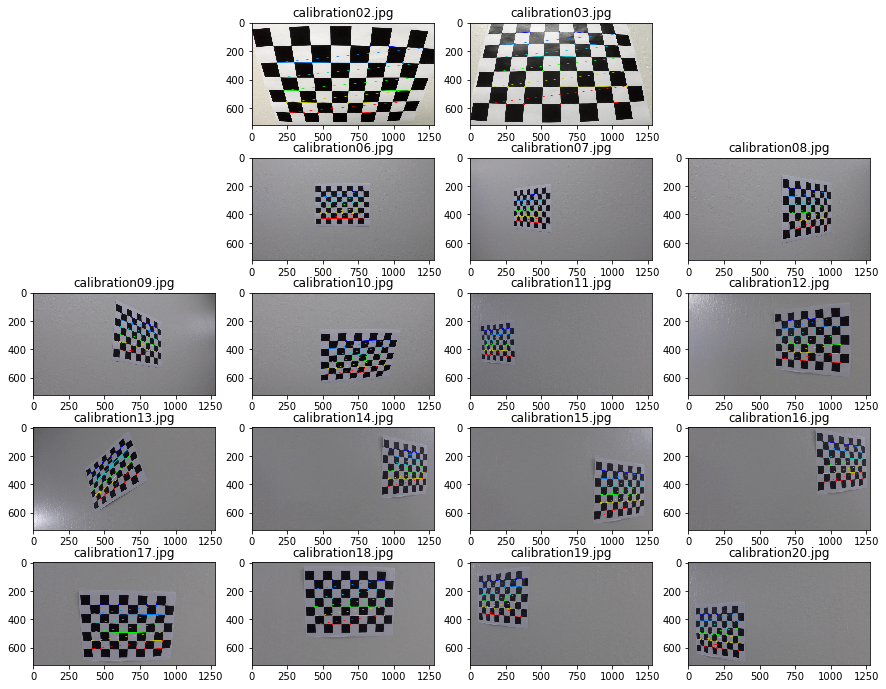

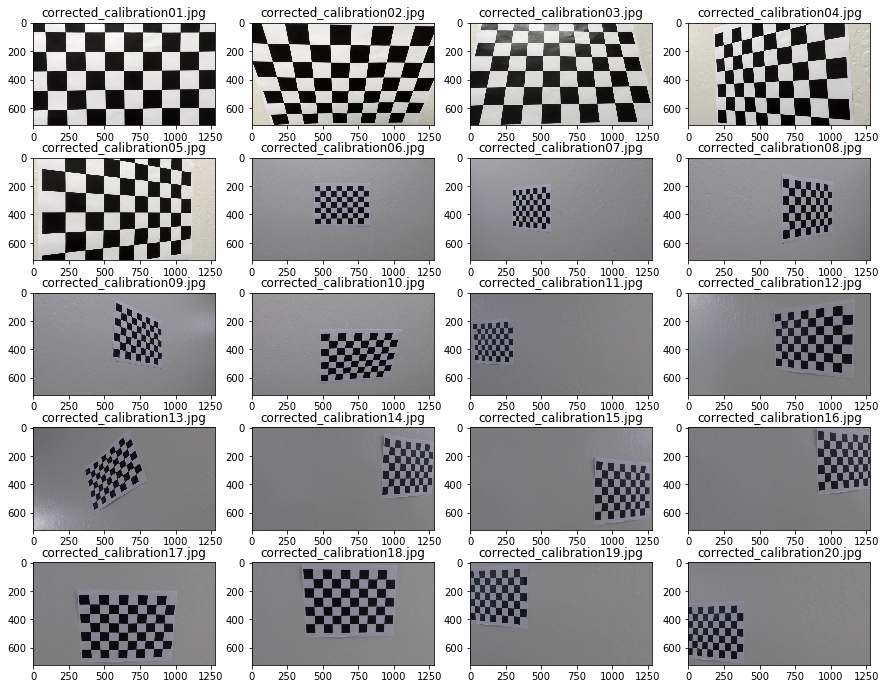

In [17]:
mtx_0, dist_0 = chessboard_calibrate(9, 6, show=True)
# mtx_1, dist_1 = chessboard_calibrate(9, 5, show=False)
# mtx_2, dist_2 = chessboard_calibrate(8, 6, show=False)

uint8 (720, 1280, 3)
uint8 (720, 1280, 3)


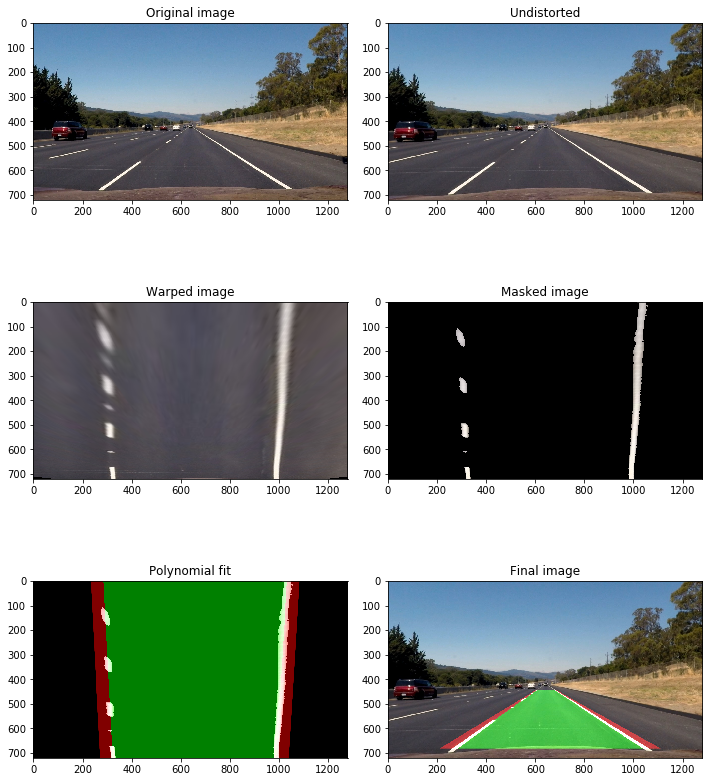

In [136]:
straight_img = mpimg.imread('./test_images/straight_lines1.jpg')
straight_img_2 = mpimg.imread('./test_images/straight_lines2.jpg')

img = straight_img_2
final = pipeline(img, show=True)

In [61]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip, TextClip, CompositeVideoClip
from IPython.display import HTML

In [128]:
white_output = 'example.mp4'

# txt_clip = TextClip("Advanced Lanelines\nChris Sketch",font='Arial',fontsize=40,color='white')
# txt_clip = txt_clip.set_pos(('center', 'top')).set_duration(8)

clip1 = VideoFileClip('./project_video.mp4')
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!

video = CompositeVideoClip([white_clip])#, txt_clip])
%time video.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video example.mp4
[MoviePy] Writing video example.mp4



 12%|█▏        | 152/1261 [00:33<03:57,  4.66it/s]


 24%|██▍       | 303/1261 [01:07<03:30,  4.55it/s]


 36%|███▌      | 454/1261 [01:40<02:58,  4.53it/s]


 48%|████▊     | 605/1261 [02:17<02:30,  4.35it/s]


 60%|█████▉    | 756/1261 [02:50<01:49,  4.59it/s]


 72%|███████▏  | 907/1261 [03:24<01:14,  4.78it/s]


 84%|████████▍ | 1057/1261 [04:00<00:44,  4.57it/s]


 96%|█████████▌| 1205/1261 [04:32<00:12,  4.62it/s]


100%|█████████▉| 1260/1261 [04:45<00:00,  4.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: example.mp4 

CPU times: user 28min 19s, sys: 6 s, total: 28min 25s
Wall time: 4min 45s


In [129]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
#     if left_x.sum() > 0  and left_y.sum() > 0:
#         left_fit = np.polyfit(left_y, left_x, 2)
#         left_fit_x = left_fit[0]*plot_y**2 + left_fit[1]*plot_y + left_fit[2]
#         pts_l = np.column_stack((left_fit_x, plot_y)).astype(np.int32)
#         cv2.polylines(overlay, [pts_l], False, (255, 0, 0), thickness=100, lineType=cv2.LINE_AA)
#     else:
#         print('No fit found, because no pixels found on left side')
#         left_fit = None
#         left_fit_x = None
#         show = False
        
#     if right_x.sum() > 0 and right_y.sum() > 0:
#         right_fit = np.polyfit(right_y, right_x, 2)
#         right_fit_x = right_fit[0]*plot_y**2 + right_fit[1]*plot_y + right_fit[2]
#         pts_r = np.column_stack((right_fit_x, plot_y)).astype(np.int32)
#         cv2.polylines(overlay_r, [pts_r], False, (0, 0, 255), thickness=100, lineType=cv2.LINE_AA)
#     else:
#         print('No fit found, because no pixels found on right side')
#         right_fit = None
#         right_fit_x = None
#         show = False
